<a href="https://colab.research.google.com/github/colinchu1/CAP4630/blob/master/HW4/HW_4(problem3_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You will adapt the notebook using VGG16 conv base for feature extraction, using data augmentation, not using dropout, fine-tuning. You will have to replace the VGG16 conv base by new conv bases. You should not use VGG19.

You should create two notebooks. Both should use the same conv base, unfreeze the same number of layers of the conv_base, but use different classifiers.

#Download Data
Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in /tmp.

In [21]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-19 20:41:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  79.5MB/s    in 0.8s    

2020-04-19 20:41:57 (79.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#Build network with MobileNetV2 convolution base and custom densely connected layers

##Load the convolutional base

In [24]:
from keras.applications import MobileNetV2

conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


##Freeze the convolutional base

In [0]:
conv_base.trainable = False

##Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8192256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 10,450,497
Trainable params: 8,192,513
Non-trainable params: 2,257,984
_________________________________________________________________


#Train the model end to end with frozen convolutional base

In [28]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 20s 205ms/step - loss: 0.4555 - acc: 0.7885 - val_loss: 0.1117 - val_acc: 0.8660
Epoch 2/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3328 - acc: 0.8520 - val_loss: 0.3094 - val_acc: 0.9030
Epoch 3/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3262 - acc: 0.8610 - val_loss: 0.4588 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 17s 173ms/step - loss: 0.2824 - acc: 0.8745 - val_loss: 0.2979 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 17s 174ms/step - loss: 0.2842 - acc: 0.8910 - val_loss: 1.0237 - val_acc: 0.9050
Epoch 6/30
100/100 [==============================] - 17s 172ms/step - loss: 0.2681 - acc: 0.8860 - val_loss: 0.7400 - val_acc: 0.9260
Epoch 7/30
100/100 [==============================] - 17s 172ms/step - loss: 0.2931 - acc: 0.8740 - val_lo

#Display curves of loss and accuracy during training

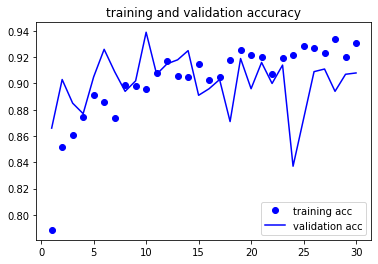

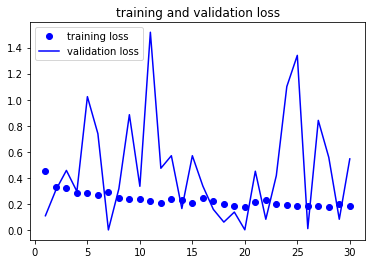

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#Fine-tuning
I chose to unfreeze block_5_expand in mobilenetV2

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block_5_expand':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [31]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 29s 289ms/step - loss: 0.1874 - acc: 0.9245 - val_loss: 0.0227 - val_acc: 0.9280
Epoch 2/30
100/100 [==============================] - 20s 200ms/step - loss: 0.1508 - acc: 0.9430 - val_loss: 0.5922 - val_acc: 0.9150
Epoch 3/30
100/100 [==============================] - 20s 200ms/step - loss: 0.1666 - acc: 0.9375 - val_loss: 0.3841 - val_acc: 0.9320
Epoch 4/30
100/100 [==============================] - 20s 201ms/step - loss: 0.1586 - acc: 0.9395 - val_loss: 2.6421e-04 - val_acc: 0.9430
Epoch 5/30
100/100 [==============================] - 20s 202ms/step - loss: 0.1609 - acc: 0.9330 - val_loss: 0.1550 - val_acc: 0.9590
Epoch 6/30
100/100 [==============================] - 20s 202ms/step - loss: 0.1504 - acc: 0.9395 - val_loss: 0.0790 - val_acc: 0.9550
Epoch 7/30
100/100 [==============================] - 20s 203ms/step - loss: 0.1308 - acc: 0.9495 - val_loss: 0.0015 - val_acc: 0.9560
Epoch 8/30
100/100 [==============================]

#Display learning curves during fine-tuning

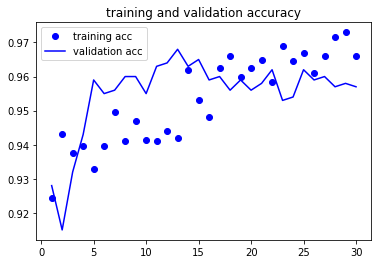

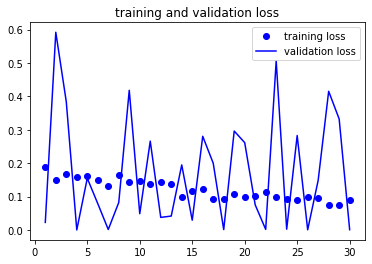

In [32]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

the validation loss fluctuating, probably caused by high learning rate

#Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [34]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.0008889109594747424
Validation accuracy: 0.9570000171661377


#Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)